<span style="color:gray">
Copyright &copy; 2020-2021 by Fraunhofer-Gesellschaft. All rights reserved.<br>
Fraunhofer Institute for Integrated Circuits IIS, Division Engineering of Adaptive Systems EAS<br>
Münchner Straße 16, 01187 Dresden, Germany
</span>

---

## ESB - Energy Saving by Blockchain

Eurostars – EXP 00119832 / EUS-2019113348

---

## Prediction of Energy Consumption for Variable Customer Portfolios Including Aleatoric Uncertainty Estimation

*Oliver Mey, André Schneider, Olaf Enge-Rosenblatt, Yesnier Bravo, Pit Stenzel*

The notebook is part of a paper submission contributed to the **10th International Conference on Power Science and Engineering (ICPSE 2021)** will be held on Oct. 21-23, 2021 in Yildiz Technical University, Istanbul, Turkey.

---

# B1: Feature Extraction

This notebook loads the available datasets and extracts the features needed as input for the prediction models for a pre-defined date (*2019-02-02*) and a customer (*#20*). The feature extraction uses pre-fitted scalers.

---

<span style="color:gray">
Version 0.4.1 (October 12, 2021)<br>
Authors: Oliver Mey, André Schneider (Fraunhofer IIS)<br>
</span>    

In [1]:
import warnings, logging, os
warnings.filterwarnings('ignore')
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
import os
import joblib
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays as hd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from datetime import datetime

%matplotlib inline
sns.set(rc={'figure.figsize':(16, 6)})

### Configuration

In [3]:
path = '..'
timezone = 'Europe/Madrid'
seed = 12345
epsilon = 1e-5
quantiles = [0.5, 0.15865, 0.84135]
skip = 15

In [4]:
properties = {
    'data_path' : path + '/data',
    'models_path' : path + '/models/C1_01',
    't_consumption_daily': [-14, -1],
    't_consumption_hourly': [-7, -1],
    't_weather_daily': [-13, 0],
    't_weather_hourly': [-2, 0],
    'epsilon': epsilon
}

### Function Definitions

In [5]:
def fix_DST(data):
    data = data[~data.index.duplicated(keep='first')]
    data = data.resample('H').ffill()
    return data

def crop(data):
    hour_index = data.index.hour
    t0 = data[hour_index==0].head(1).index
    tn = data[hour_index==23].tail(1).index
    data.drop(data.loc[data.index < t0[0]].index, inplace=True)
    data.drop(data.loc[data.index > tn[0]].index, inplace=True)
    return

def time_from_to(date, t):
    t0_ = pd.Timestamp(date)+pd.Timedelta(days=t[0])
    tn_ = pd.Timestamp(date)+pd.Timedelta(days=t[1])+pd.Timedelta(hours=23)
    return slice(t0_, tn_)

def day_from_to(date, t):
    t0_ = pd.Timestamp(date)+pd.Timedelta(days=t[0])
    tn_ = pd.Timestamp(date)+pd.Timedelta(days=t[1])
    return slice(t0_, tn_)

### Class Definitions

#### Data Loader

In [6]:
class DataLoader:
    
    def __init__(self, properties):
        self.data_path = properties.get('data_path', '/tmp')
        self.categories = ['consumption', 'weather', 'profiles']
        self.files = [self.data_path + '/' + '20201015_' + name + '.xlsx' for name in self.categories]
        return
    
    def scale_data(self, data):
        x = data.groupby(data.index.date).mean()
        x.index = pd.to_datetime(x.index)
        x = x.append(pd.DataFrame(x.tail(1), index=x.tail(1).index+pd.Timedelta(days=1)))
        x = x.resample('h').ffill()[:-1]
        x.index = data.index
        y = data / x
        return y
    
    def load_metadata(self):
        customers = pd.read_excel(self.files[self.categories.index('profiles')])
        customers.columns = ['customer', 'profile']
        profiles = pd.DataFrame(customers['profile'].unique(), columns=['profile'])
        holidays = hd.ES(years=list(range(2010, 2021)), prov="MD")
        return customers, profiles, holidays
    
    def load_data(self):
        consumptions = pd.read_excel(self.files[self.categories.index('consumption')], parse_dates=[0], index_col=0)
        consumptions.columns = pd.DataFrame(consumptions.columns, columns=['customer']).index
        consumptions.index.name = 'time'
        consumptions = fix_DST(consumptions)
        crop(consumptions)
        consumptions_scaled = self.scale_data(consumptions)
        weather = pd.read_excel(self.files[self.categories.index('weather')], parse_dates=[0], index_col=0)
        weather.columns = consumptions.columns
        weather.index.name = 'time'
        weather = fix_DST(weather)
        weather_forecast = weather.copy()
        weather_forecast.index = weather.index-pd.Timedelta(days=1)
        crop(weather)
        crop(weather_forecast)
        return consumptions, consumptions_scaled, weather, weather_forecast
    
    def prepare_data(self, consumptions, weather, holidays):
        days = pd.DataFrame(pd.to_datetime(consumptions.index.date), index=consumptions.index, columns=['date'])
        days['day_of_week'] = list(days.index.dayofweek)
        days['day_of_month'] = list(days.index.day)
        days['month'] = list(days.index.month)
        days['day_category'] = days['day_of_week'].replace({0:0,1:1,2:1,3:1,4:2,5:3,6:4})
        days.loc[days['date'].apply(lambda d: d in holidays), 'day_category'] = 4
        days = days.groupby(['date']).first()
        consumptions_daily_mean = pd.DataFrame(consumptions.groupby(consumptions.index.date).mean(), index=days.index)
        weather_daily_mean = pd.DataFrame(weather.groupby(weather.index.date).mean(), index=days.index)
        return consumptions_daily_mean, weather_daily_mean, days

#### Feature Extractor

In [7]:
class FeatureExtractor:
    
    def __init__(self, properties, customers, consumptions, consumptions_scaled, weather, 
                 weather_forecast, holidays):
        self.models_path = properties.get('models_path', '/tmp')
        self.t_consumption_daily = properties.get('t_consumption_daily', [-13, -1])
        self.t_consumption_hourly = properties.get('t_consumption_hourly', [-2, -1])
        self.t_weather_daily = properties.get('t_weather_daily', [-2, -0])
        self.t_weather_hourly = properties.get('t_weather_hourly', [-2, -0])
        self.encoder = properties.get('encoder')
        self.epsilon = properties.get('epsilon', 1e-5)
        self.scaler_names = ['consumptions', 'consumptions_daily_mean',
                             'weather_daily_mean', 'day_of_month', 'month',
                             'weather_forecast']
        self.scalers = properties.get('scalers', {})
        self.customers = customers
        self.consumptions = consumptions
        self.consumptions_scaled = consumptions_scaled
        self.weather = weather
        self.weather_forecast = weather_forecast
        self.holidays = holidays
        self.days = self.get_days(consumptions.index, holidays)
        self.consumptions_daily_mean = pd.DataFrame(consumptions.groupby(consumptions.index.date).mean(), 
                                               index=self.days.index)
        self.weather_daily_mean = pd.DataFrame(weather.groupby(weather.index.date).mean(), 
                                               index=self.days.index)
        return

    def get_days(self, dates, holidays):
        days = pd.DataFrame(pd.to_datetime(dates.date), index=dates, columns=['date'])
        days['day_of_week'] = list(days.index.dayofweek)
        days['day_of_month'] = list(days.index.day)
        days['month'] = list(days.index.month)
        days['day_category'] = days['day_of_week'].replace({0:0,1:1,2:1,3:1,4:2,5:3,6:4})
        days.loc[days['date'].apply(lambda d: d in holidays), 'day_category'] = 4
        days = days.groupby(['date']).first()
        return days
        
    def split(self, indices, seed=12345):
        n = len(indices)
        n_validate = n//10
        n_test = n//10
        n_train = n-n_validate - n_test
        np.random.seed(seed)
        I = np.random.permutation(indices)
        I_train = I[0:n_train]
        I_test = I[n_train:n_train + n_test]
        I_validate = I[n_train + n_test:]
        return I_train, I_test, I_validate

    def fit(self):
        I_train, I_test, I_validate = self.split(self.customers, seed)
        self.scalers['consumptions'] = RobustScaler(quantile_range=(0,75))
        self.scalers['consumptions'].fit(self.consumptions_daily_mean.loc[:, I_train].values.reshape(-1, 1))
        self.scalers['weather'] = RobustScaler(quantile_range=(0,75))
        self.scalers['weather'].fit(self.weather_daily_mean.loc[:, I_train].values.reshape(-1, 1))
        self.scalers['day_of_month'] = RobustScaler(quantile_range=(0,75))
        self.scalers['day_of_month'].fit(self.days['day_of_month'].values.reshape(-1, 1))
        self.scalers['month'] = RobustScaler(quantile_range=(0,75))
        self.scalers['month'].fit(self.days['month'].values.reshape(-1, 1))
        X = self.weather_forecast.loc[:, I_train]
        X.index = pd.MultiIndex.from_arrays([X.index.date, X.index.time], names=['date','time'])
        X = X.stack().unstack(level=1)
        self.scalers['weather_forecast'] = RobustScaler(quantile_range=(0,75))
        self.scalers['weather_forecast'].fit(X)
        dates = self.consumptions_daily_mean.index.date
        return [I_train, I_test, I_validate], dates, self.scalers
    
    def load(self):
        scalers = [joblib.load(self.models_path + '/' + name) for name in self.scaler_names]
        self.scalers = dict(zip(self.scaler_names, scalers))
        return
    
    def extract(self, date, customers):
        n = len(customers)
        X1 = self.consumptions_scaled.loc[time_from_to(date, self.t_consumption_hourly),customers].values.T
        X1 = X1 + self.epsilon
        X2 = self.weather.loc[time_from_to(date, self.t_weather_hourly),customers].values.T
        X2 = self.scalers['weather_forecast'].transform(X2.reshape(-1,24)).reshape(n, -1)
        X2 = (X2 + 1) / 2
        X3 = self.days.loc[pd.Timestamp(date),'day_of_month']
        X3 = np.ones((n, 1)) * X3
        X3 = self.scalers['day_of_month'].transform(X3)
        X3 = (X3 + 1) / 2
        X4 = self.days.loc[pd.Timestamp(date),'month']
        X4 = np.ones((n, 1)) * X4
        X4 = self.scalers['month'].transform(X4)
        X4 = (X4 + 1) / 2
        X5 = self.days.loc[pd.Timestamp(date),'day_category']
        X5 = np.ones((n, 1)) * X5
        X5 = self.encoder.transform(X5)
        X6 = self.consumptions_daily_mean.loc[day_from_to(date, self.t_consumption_daily), customers].values.T
        X6 = X6 / (2 * self.scalers['consumptions'].scale_) + self.epsilon
        X7 = self.weather_daily_mean.loc[day_from_to(date, self.t_weather_daily), customers].values.T
        X7 = self.scalers['weather'].transform(X7.reshape(-1, 1)).reshape(n, -1)
        X7 = (X7 + 1) / 2
        Xa = np.nan_to_num(np.concatenate([X1, X2, X3, X4, X5], axis=1))
        Xb = np.nan_to_num(np.concatenate([X6, X7, X3, X4, X5], axis=1))
        return [Xa, Xb]

### Loading Data

In [8]:
loader = DataLoader(properties)
consumptions, consumptions_scaled, weather, weather_forecast = loader.load_data()
customers, profiles, holidays = loader.load_metadata()
encoder = OneHotEncoder(sparse=False)
_ = encoder.fit(np.arange(5).reshape(-1,1))

In [9]:
properties['encoder'] = encoder

### Extracting Features

In [10]:
selected_customers = customers[customers['profile'].astype(str).str.contains('hogares')].index.values

In [11]:
extractor = FeatureExtractor(properties, selected_customers, consumptions, consumptions_scaled,
                             weather, weather_forecast, holidays)

In [12]:
I, dates, scalers = extractor.fit()

In [13]:
features = [[extractor.extract(date, Ii) for date in dates[15:]] for Ii in I]

### Results: 2 Feature Vectors Xa, Xb

The feature vector *Xa* contains 168 scaled consumption values (past 7 days, hourly), 72 scaled temperature values (weather of the past 2 days, hourly and weather forecast for the current day, hourly), the day of month, the month, and the onehot encoded day category. In total, *Xa* consists of **247** values.

The feature vector *Xb* contains 14 scaled daily mean consumption values (past 14 days), 14 scaled daily mean temperature values (past 13 days and forecast for the current day), the day of month, the month, and the onehot encoded day category. In total, *Xb* consists of **35** values.

In [14]:
Xa, Xb = features[1][0][0], features[1][0][1]

In [15]:
Xa.shape, Xb.shape

((31, 247), (31, 35))

In [16]:
print(Xa)

[[1.50040346 1.43535144 0.99047953 ... 0.         0.         0.        ]
 [3.07341324 0.76264108 0.30506243 ... 0.         0.         0.        ]
 [3.32322362 3.1514354  0.34062459 ... 0.         0.         0.        ]
 ...
 [2.46919953 2.45427995 2.35730272 ... 0.         0.         0.        ]
 [0.6861781  0.6893548  0.63852754 ... 0.         0.         0.        ]
 [1.98075064 0.07911554 0.07446227 ... 0.         0.         0.        ]]


In [17]:
print(Xb)

[[0.5625147  0.33254103 0.47375953 ... 0.         0.         0.        ]
 [0.22573396 0.17973922 0.19113448 ... 0.         0.         0.        ]
 [0.13118713 0.40967529 0.5782349  ... 0.         0.         0.        ]
 ...
 [0.48304874 0.531488   0.43916006 ... 0.         0.         0.        ]
 [0.35627175 0.32133381 0.33325558 ... 0.         0.         0.        ]
 [0.09057036 0.50294343 0.40155193 ... 0.         0.         0.        ]]


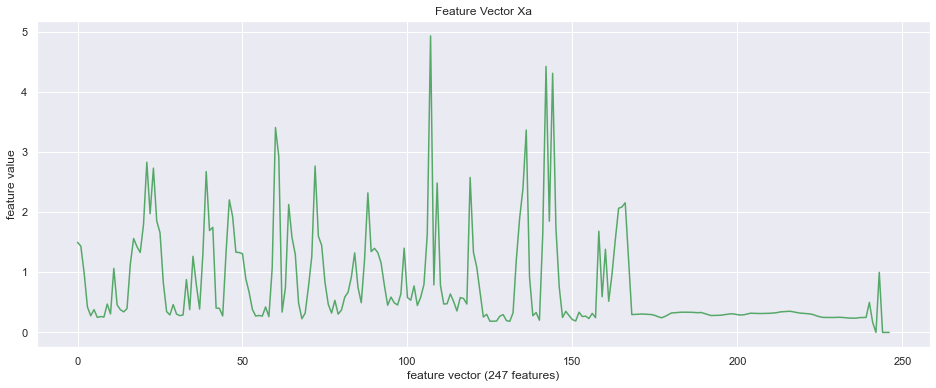

In [18]:
plt.plot(Xa[0], color='g')
plt.xlabel('feature vector (247 features)')
plt.ylabel('feature value')
plt.title('Feature Vector Xa')
plt.show()

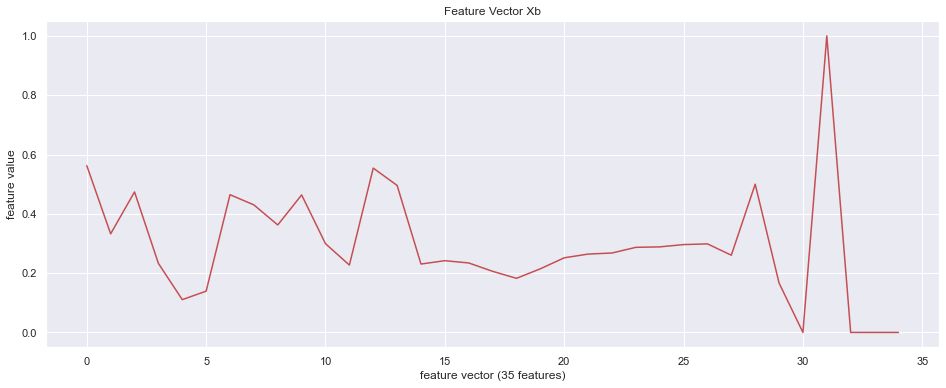

In [19]:
plt.plot(Xb[0], color='r')
plt.xlabel('feature vector (35 features)')
plt.ylabel('feature value')
plt.title('Feature Vector Xb')
plt.show()